Liste des imports :

In [1]:
import os.path 
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
from csv import reader

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans


# 1. Chargement des données

Méthode pour télécharger les données si elles ne sont pas déjà téléchargées.

In [2]:
def download_data(path, filename, url):
    csv_local_path = path + filename
    if not os.path.isfile(csv_local_path):
        with urlopen(url + filename + '.zip') as zip_response:
            with ZipFile(BytesIO(zip_response.read())) as zip_file:
                zip_file.extractall(path)
path = 'data/'
csv_name = 'fr.openfoodfacts.org.products.csv'
url = 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/'
download_data(path, csv_name, url)

In [3]:
csv_local_path = path + csv_name

## 1.1 Problèmes de lecture des données

Import des données :

In [4]:
df = pd.read_csv(csv_local_path, sep='\t', encoding='utf-8', low_memory=False)

On teste si la colonne code peut être transformé en entier.

In [5]:
irregular_rows = []
i = 0
for code in df.code:
    try:
        int(code)
    except:
        irregular_rows.extend([i, i + 1])
    i = i + 1

len(irregular_rows)

46

On détecte 23 lignes qui posent problème. Il faut maintenant pouvoir les lire.
[Le code a été revu pour enregister les indices des lignes précédentes, on trouve donc le double.]

Méthode pour lire des lignes choisies dans l'objectif de regarder les lignes qui posent problème.

In [6]:
def read_lines(csv_local_path, indices):
    with open(csv_local_path, 'r', encoding='utf-8') as csv_file:
        i = 0
        csv_reader = reader(csv_file)
        for row in csv_reader:
            if i in indices:
                print(row)
            i += 1

In [7]:
# read_lines(irregular_rows)

On détecte que des saut de lignes sont effectués après la variable 'first_packaging_code_geo'. </br>
Plusieurs produits ont donc une partie de leur données sur une ligne et l'autre partie sur la ligne suivante.</br>
On peut essayer de supprimer les sauts de ligne dans le fichier source.</br>

## 1.2 Traitement du fichier source

On remplace les sauts de ligne suivi d'une tabulation par une simple tabulation.</br>
Il n'y a pas de tabulation en début de ligne donc seul les sauts de ligne mal placés vont sauter.</br>

In [8]:
clean_name = 'clean_food_data.csv'
clean_csv_local_path = path + clean_name

if not os.path.isfile(clean_csv_local_path):
    with open(csv_local_path, 'r', encoding='utf-8') as csv_file, open(clean_csv_local_path, 'w', encoding='utf-8') as clean_file:
        df = csv_file.read()
        clean_file.write(df.replace('\n\t', '\t'))

In [9]:
column_names = pd.read_csv(clean_csv_local_path, sep='\t', encoding='utf-8', nrows=0).columns.values

## 1.3 Préparation du type de colonnes

In [10]:
columns_dtype = {}
for column in column_names:
    if column.endswith('_100g'):
        columns_dtype[column] = 'float'
    elif column.endswith(('_n', '_t')):
        columns_dtype[column] = 'int64'
    else:
        columns_dtype[column] = 'str'

Certaines colonnes de nombres entiers posent problème dans la lecture des NaN. On enlève leur dtype et on le traitera une fois les NaN supprimées.

In [11]:
int_columns = {'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n'}

del columns_dtype['additives_n']
del columns_dtype['ingredients_from_palm_oil_n']
del columns_dtype['ingredients_that_may_be_from_palm_oil_n']

In [12]:
df = pd.read_csv(clean_csv_local_path, sep='\t', encoding='utf-8', dtype=columns_dtype)

In [13]:
df.shape

(320749, 162)

In [14]:
df.dtypes.value_counts()

float64    102
object      58
int64        2
dtype: int64

In [15]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Exploration

On renomme plusieurs colonnes pour avoir plus de possibilité avec Python ou pour simplifier leur écriture.

In [16]:
new_names = {
    'saturated-fat_100g': 'saturated_fat_100g',
    'fruits-vegetables-nuts_100g': 'fruits_vegetables_nuts_100g',
    'monounsaturated-fat_100g': 'monounsaturated_fat_100g',
    'polyunsaturated-fat_100g': 'polyunsaturated_fat_100g',
    'trans-fat_100g' : 'trans_fat_100g',
    'vitamin-a_100g' : 'vitamin_a_100g',
    'vitamin-d_100g' : 'vitamin_d_100g',
    'vitamin-c_100g' : 'vitamin_c_100g',
    'vitamin-b1_100g' : 'vitamin_b1_100g',
    'vitamin-b2_100g' : 'vitamin_b2_100g',
    'vitamin-pp_100g' : 'vitamin_pp_100g',
    'vitamin-b6_100g' : 'vitamin_b6_100g',
    'vitamin-b9_100g' : 'vitamin_b9_100g',
    'vitamin-b12_100g' : 'vitamin_b12_100g',
    'nutrition-score-fr_100g': 'nutrition_score_fr_100g',
    'nutrition-score-uk_100g': 'nutrition_score_uk_100g',
    'ingredients_from_palm_oil_n': 'palm_oil_n',
    'ingredients_that_may_be_from_palm_oil_n': 'may_be_palm_oil_n',
    }
df.rename(columns=new_names, inplace=True)

## 1. Quelques Méthodes

On définit des méthodes pour 
1. Calculer le pourcentage de NaN,
2. Supprimer les colonnes trop remplies de NaN selon une limite que l'on peut ajuster,
3. Présenter la répartition des valeurs prises pour chaque variable qualitative spécifiée.

In [17]:
def evaluate_nan_percentage(serie):
    return serie.isna().sum()/serie.size

In [18]:
def describe_qualitative_columns(dataframe, columns, top=10, dropna=False):
    print(35 * '-'+ 'Pourcentage de NaN' + 35 * '-')
    print(dataframe[columns].isna().sum() / dataframe.shape[0])
    print(30 * '-'+ 'Compte des valeurs par variable' + 30 * '-')
    for column in columns:
        print((50 - len(column)) * '-'+ column + (50 - len(column)) * '-')
        if len(dataframe[column].value_counts(dropna=dropna)) > top:
            print(dataframe[column].value_counts(dropna=dropna)[:top])
        else:
            print(dataframe[column].value_counts(dropna=dropna))


### Méthode pour éliminer les colonnes vides

In [19]:
def drop_nan_columns(dataframe, nan_percentage_limit, exceptions=[]):
    """
    Determine which columns has too many NaN values.
    Then it drop the given columns from the dataframe.
    """
    dropped_columns = []
    for column in dataframe.columns:
        if column not in exceptions:
            nan_percentage = evaluate_nan_percentage(dataframe[column])
            if nan_percentage > nan_percentage_limit:
                dropped_columns.append(column)
    return dataframe.drop(columns=dropped_columns)

### Méthode pour connaître les indices des NaN

In [20]:
def nan_indices(serie):
    return serie[serie.isna()==True].index

### Méthode pour connaître les indices des outliers

In [21]:
def outliers_indices(serie, inf, sup):
    outliers = (serie[serie>sup].index).append(serie[serie<inf].index)
    return outliers

def outliers_indices_IQR(serie):
    q75, q25 = np.percentile(serie, [75 ,25])
    iqr = (q75 - q25) * 1.5
    max = q75 + iqr
    min = q25 - iqr
    outliers = (serie[serie>max].index).append(serie[serie<min].index)
    return outliers

### Méthode pour supprimer les NaN, outliers, zéro

In [22]:
def clean_outliers(serie):
    serie = serie.dropna()
    serie = serie.drop(outliers_indices_IQR(serie))
    return serie

def clean_zeros(serie):
    serie = serie.dropna()
    serie = serie.drop(serie[serie==0].index)
    serie = serie.drop(outliers_indices_IQR(serie))
    return serie

### Méthode pour heatmap avec compte de NaN croissant

In [23]:
def heatmap_nan_sorted(df, columns):
    sorted_columns = df[columns].isna().sum().sort_values().index
    sns.heatmap(df[sorted_columns].isna())

## 2.1 Détection des doublons

Pour effectuer des modfications sur les données mais conserver la base initiale, on réalise une copie.

In [24]:
work_df = df.copy()

In [25]:
work_df.duplicated('code').sum()

0

On ne détecte pas de doublon selon la colonne 'code'. On peut la définir comme index.

In [26]:
work_df.set_index('code')
print("")

On peut supposer que si les produits sont de même composition et de même pays de vente, il s'agit de doublon.

In [27]:
work_df.columns[34:].insert(loc=0, item='countries_fr')

Index(['countries_fr', 'ingredients_text', 'allergens', 'allergens_fr',
       'traces', 'traces_tags', 'traces_fr', 'serving_size', 'no_nutriments',
       'additives_n',
       ...
       'ph_100g', 'fruits_vegetables_nuts_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition_score_fr_100g',
       'nutrition_score_uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=129)

In [28]:
work_df[work_df.duplicated(work_df.columns[34:])].index
len(work_df[work_df.duplicated(work_df.columns[34:])].index) * 100 / work_df.shape[0]

13.297313475646066

Ces doublons représentent 13% des données. Le pourcentage n'est pas négligeable.  
Pour que ces doublons ne fausse pas certaines analyse, on choisit de supprimer ces doublons sachant que l'on conserve un jeu de données de 278 000 individus.

In [29]:
work_df.drop_duplicates(subset=work_df.columns[34:], inplace=True)
work_df.shape

(278098, 162)

In [30]:
work_df.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'ph_100g', 'fruits_vegetables_nuts_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition_score_fr_100g',
       'nutrition_score_uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=162)

1. On cible tout d'abord les colonnes assez remplies.
2. On trie ensemble les variables redondantes pour selectionner ou recomposer de nouvelles.
3. Enfin on passe en revue les colonnes par ordre de pertinence.  

## 2.2 Ciblage

In [31]:
work_df = drop_nan_columns(work_df, 0.90)
work_df.shape

(278098, 65)

Il reste 65 colonnes pour 278 000 individus.

## 2.3 Tri des variables

In [32]:
work_df.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands',
       'brands_tags', 'categories', 'categories_tags', 'categories_fr',
       'manufacturing_places', 'manufacturing_places_tags', 'labels',
       'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags',
       'purchase_places', 'stores', 'countries', 'countries_tags',
       'countries_fr', 'ingredients_text', 'allergens', 'serving_size',
       'additives_n', 'additives', 'additives_tags', 'additives_fr',
       'palm_oil_n', 'may_be_palm_oil_n', 'nutrition_grade_fr',
       'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags', 'states_fr',
       'main_category', 'main_category_fr', 'image_url', 'image_small_url',
       'energy_100g', 'fat_100g', 'saturated_fat_100g', 'trans_fat_100g',
       'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
   

On identifie beaucoup de colonnes de composition qui terminent par _100g.  
On différencie la colonne energy et les colonnes nutrition-score de la majorité des colonnes qui sont en g ou ml pour 100g, 100ml.  
Les éléments nutritionnels représentent beaucoup de colonnes, les données sont importantes pour notre objectif autour de la santé.  

On a 
- des colonnes de score nutrition
- des colonnes sur la composition des aliments :
    - dont le elements_columns déjà créés
    - dont les additives
    - dont les allergènes
    - dont les ingrédient avec de l'huile de palme
    - la liste des ingrédients

- des colonnes identifiant le produit,
- des colonnes propres à la fiche d'information,
- des colonnes autour des quantités,
- des colonnes sur l'emballage,
- des colonnes sur la classification,
- des colonnes sur la localisation (vente/production)



In [33]:
non_relevant_columns = set()
start_work_df = work_df.copy()

#### a) Identifiants

In [34]:
id_columns = {'code', 'generic_name', 'product_name'}

Ces colonnes renseigne sur le produit. On ne conserve pas ces données.

In [35]:
non_relevant_columns.update(id_columns)

#### b) Fiche produit

In [36]:
sheet_columns = {'url', 'creator', 'created_t', 'created_datetime',
                 'last_modified_t', 'last_modified_datetime',
                 'image_url', 'image_small_url',
                 'states', 'states_tags', 'states_fr'}

Ces colonnes nous informe sur la fiche produit, elle ne nous sont donc pas utiles.

In [37]:
non_relevant_columns.update(sheet_columns)

#### c) Quantités

In [38]:
quantity_columns = {'quantity','serving_size'}

In [39]:
describe_qualitative_columns(start_work_df, quantity_columns)

-----------------------------------Pourcentage de NaN-----------------------------------
quantity        0.666689
serving_size    0.299596
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
------------------------------------------quantity------------------------------------------
NaN      185405
500 g      4272
200 g      3795
250 g      3620
100 g      2843
400 g      2329
300 g      2325
150 g      2179
1 l        1545
1 kg       1463
Name: quantity, dtype: int64
--------------------------------------serving_size--------------------------------------
NaN                 83317
240 ml (8 fl oz)     4686
28 g (1 oz)          4675
28 g (1 ONZ)         3484
30 g (2 Tbsp)        2675
30 g                 2583
15 ml (1 Tbsp)       2265
30 g (0.25 cup)      1850
100 g                1645
240 ml (1 cup)       1624
Name: serving_size, dtype: int64


Les deux données sont proches, l'une est le poids total, l'autre la part servie.  
Elle sont néanmoins qualitatives car l'unité n'est pas unique.  
Le traitement pour les rendre quantitatives semble complexe:
 - il y a deux grandeurs selon s'il s'agit d'un liquide ou non (Volume ou masse).
 - dans une même grandeur, pas d'unité unique
 - la donnée peut contenir le détail des masses des sous emballage.  
 
La donnée 'serving_size' est plutôt bien renseignée (30% de NaN).


In [40]:
non_relevant_columns.update(quantity_columns)

#### d) Emballages

In [41]:
packaging_columns = {'packaging', 'packaging_tags', 'emb_codes', 'emb_codes_tags'}

In [42]:
describe_qualitative_columns(start_work_df, packaging_columns)

-----------------------------------Pourcentage de NaN-----------------------------------
packaging         0.725298
emb_codes_tags    0.895145
emb_codes         0.895130
packaging_tags    0.725287
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
-----------------------------------------packaging-----------------------------------------
NaN                    201704
Carton                   2148
Sachet,Plastique         2124
Plastique                1895
Bouteille,Verre          1318
Conserve                 1277
Kunststoff               1272
sachet,plastique         1110
Bocal,Verre              1102
Bouteille,Plastique      1021
Name: packaging, dtype: int64
------------------------------------emb_codes_tags------------------------------------
NaN                 248938
emb-56251e             215
fr-85-154-002-ec       128
emb-49331h             105
fr-72-264-002-ec       102
fr-29-247-022-ec       102
emb-45273              10

Il s'agit de quatres données qualitatives.  
On choisit de se séparer de ces variables puisque :
- Les données sont mal renseignées de 72% à 89% de NaN, très morcelées et pas homogènes.  
- De plus les unités ne sont pas homogènes, même pour une même grandeur (Masse ou volume).  
- Le rapport avec la santé n'apparaît pas évident.



In [43]:
non_relevant_columns.update(packaging_columns)

#### e) Catégories

On trouve un certain nombre de variable qui cherche à catégoriser les produits.  
On retrouve des groupes PNNS du Programme National Nutrition Santé.

In [44]:
category_columns = {
                     'main_category', 'main_category_fr',
                     'categories', 'categories_tags', 'categories_fr',
                     'pnns_groups_1','pnns_groups_2'
}

In [45]:
describe_qualitative_columns(start_work_df, category_columns)

-----------------------------------Pourcentage de NaN-----------------------------------
pnns_groups_1       0.681580
main_category_fr    0.700746
main_category       0.700746
categories_tags     0.700746
pnns_groups_2       0.671432
categories_fr       0.700746
categories          0.700746
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
-------------------------------------pnns_groups_1-------------------------------------
NaN                        189546
unknown                     20436
Sugary snacks               12240
Beverages                    8875
Milk and dairy products      8744
Cereals and potatoes         8351
Fish Meat Eggs               7963
Composite foods              6694
Fruits and vegetables        5835
Fat and sauces               5137
Name: pnns_groups_1, dtype: int64
----------------------------------main_category_fr----------------------------------
NaN                                        194876
Bois

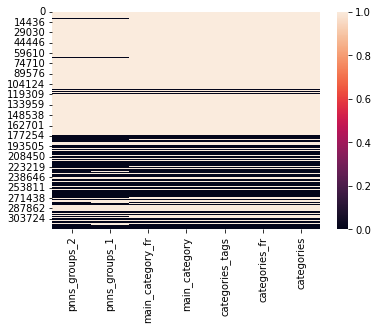

In [46]:
heatmap_nan_sorted(start_work_df, category_columns)

Les variables sont redondantes et on voit distingue deux groupes où les NaN correspondent parfaitement :
 - les groupes PNNS 1 et 2
 - les variables avec le mot category
 
Elles sont globalement, mal renseignées repectivement 67% et 70% de NaN.  

On choisit de recomposer une variable category avec les données des deux groupes de variables :
 - d'un côté pnns_groups_1
 - de l'autre la variable main_category

In [47]:
work_df['category'] = work_df.pnns_groups_1.replace({
    'fruits-and-vegetables': 'Fruits and vegetables',
    'sugary-snacks': 'Sugary snacks',
    'cereals-and-potatoes': 'Cereals and potatoes',
    'salty-snacks': 'Salty snacks',
})

On utilise les groupes PNNS comme repère de catégorie.

In [48]:
work_df.category = work_df.category.fillna(work_df.pnns_groups_2)

work_df.category = work_df.category.fillna(work_df.main_category_fr)
match = {'Alcoholic beverages': 'Beverages',
         'Tripe dishes': 'Fish Meat Eggs',
         'unknown': pd.NA,
}
work_df.category = work_df.category.replace(match)

In [49]:
work_df.category.value_counts(dropna=False, normalize=True)

NaN                        0.744917
Sugary snacks              0.045775
Beverages                  0.041813
Milk and dairy products    0.031442
Cereals and potatoes       0.030087
Fish Meat Eggs             0.028882
Fruits and vegetables      0.024517
Composite foods            0.024071
Fat and sauces             0.018472
Salty snacks               0.010025
Name: category, dtype: float64

##### Bilan
On conserve 74% de NaN, plus qu'indiqué plus haut mais le chiffre ne tenait pas compte de la catégorie 'unknown'.

In [50]:
non_relevant_columns.update(category_columns)

#### d) Marque

In [51]:
brands_columns = {'stores', 'brands', 'brands_tags'}

In [52]:
describe_qualitative_columns(start_work_df, brands_columns)

-----------------------------------Pourcentage de NaN-----------------------------------
stores         0.815989
brands_tags    0.047214
brands         0.047196
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
--------------------------------------------stores--------------------------------------------
NaN            226925
Carrefour        6436
Auchan           2864
Leclerc          2824
Cora             2264
Intermarché      2202
Lidl             1719
Franprix         1642
Aldi             1392
Super U          1352
Name: stores, dtype: int64
---------------------------------------brands_tags---------------------------------------
NaN             13130
carrefour        2945
auchan           2246
u                1950
leader-price     1795
meijer           1561
kroger           1544
casino           1540
ahold            1207
spartan          1182
Name: brands_tags, dtype: int64
--------------------------------------------bran

Les variables 'stores' nous permet de connaître l'enseigne. On peut donc l'utiliser pour alimenter les NaN de 'brands'.

In [53]:
work_df['brands'].fillna(work_df['stores'], inplace=True)

In [54]:
work_df['brands'].fillna("Aucun", inplace=True)

In [55]:
non_relevant_columns.update({'stores', 'brands_tags'})

#### e) Lieu

In [56]:
location_columns = {
                     'countries', 'countries_tags', 'countries_fr',
                     'manufacturing_places', 'manufacturing_places_tags',
                     'purchase_places'
}

In [57]:
describe_qualitative_columns(start_work_df, location_columns)

-----------------------------------Pourcentage de NaN-----------------------------------
purchase_places              0.792116
manufacturing_places         0.869427
manufacturing_places_tags    0.869449
countries_tags               0.000716
countries                    0.000716
countries_fr                 0.000716
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
-----------------------------------purchase_places-----------------------------------
NaN                         220286
France                       11724
Lyon,France                   3085
Courrières,France             2267
Madrid,España                 2000
Paris,France                  1926
España                        1222
Rennes,France                 1127
Deutschland                   1028
Liverpool,United Kingdom       921
Name: purchase_places, dtype: int64
------------------------------manufacturing_places------------------------------
NaN                2417

In [58]:
start_work_df[location_columns].isna().sum().sort_values().index

Index(['countries_tags', 'countries', 'countries_fr', 'purchase_places',
       'manufacturing_places', 'manufacturing_places_tags'],
      dtype='object')

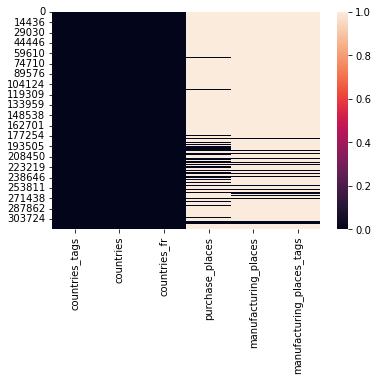

In [59]:
heatmap_nan_sorted(start_work_df, location_columns)

Les variables 'manufactoring_places', 'purchase_places' sont à la fois trop détaillées et remplies de NaN.</br>
Les variables de pays on l'avantage d'être bien renseignée sans NaN, mais redondantes, il faut en conserver une :</br>
'countries_fr' semble la plus appropriée.

In [60]:
non_relevant_columns.update({'countries',
                             'countries_tags',
                             'manufacturing_places',
                             'manufacturing_places_tags',
                             'purchase_places'})

#### f) Labels

In [61]:
labels_columns = {'labels', 'labels_tags', 'labels_fr'}

In [62]:
describe_qualitative_columns(start_work_df,labels_columns)

-----------------------------------Pourcentage de NaN-----------------------------------
labels         0.835522
labels_tags    0.835216
labels_fr      0.835216
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
--------------------------------------------labels--------------------------------------------
NaN                                                     232357
Organic, EU Organic, fr:AB Agriculture Biologique         3121
Point Vert                                                2035
Vegetariano,Vegano                                        1047
Bio,Bio européen,AB Agriculture Biologique                 972
Point Vert,Eco-Emballages                                  609
AB,Bio européen                                            407
AOP                                                        399
Produit en Bretagne                                        388
Bio,Bio européen,FR-BIO-01,AB Agriculture Biologique       320
Name: l

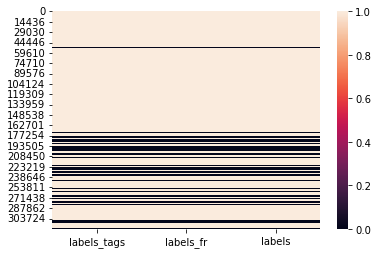

In [63]:
heatmap_nan_sorted(start_work_df, labels_columns)

On compte 85% de NaN qui coïncident pour les différentes variables.  
Le fait d'avoir un label est assez rare, donc on peut supposer que l'absence signifie qu'il n'y a pas de label.  
On choisit de conserver 'label_fr'.  

In [64]:
work_df.labels_fr = work_df.labels_fr.notnull()

In [65]:
non_relevant_columns.update({'labels', 'labels_tags'})

#### g) Constituants

In [66]:
energy_columns = set()
nutrition_score_columns = set()
elements_columns = set()

for column in work_df.columns:
    if 'energy' in column:
        energy_columns.add(column)
    elif 'nutrition_score' in column:
        nutrition_score_columns.add(column)
    elif column.endswith('_100g') and evaluate_nan_percentage(work_df[column]) < 0.90:
        elements_columns.add(column)


In [67]:
additives_columns = {'additives_n', 'additives', 'additives_tags', 'additives_fr'}
palm_oil_columns = {
       'palm_oil_n',
       'may_be_palm_oil_n', 
}


1. Traitement des NaN

In [98]:
(clean_df[elements_columns].isna().sum()/clean_df.shape[0]).sort_values()

sugars_100g           0.000908
sodium_100g           0.000908
proteins_100g         0.000908
saturated_fat_100g    0.000908
salt_100g             0.000908
fat_100g              0.081546
carbohydrates_100g    0.081670
fiber_100g            0.129915
cholesterol_100g      0.398313
calcium_100g          0.405405
trans_fat_100g        0.406719
iron_100g             0.409725
vitamin_c_100g        0.416818
vitamin_a_100g        0.420885
dtype: float64

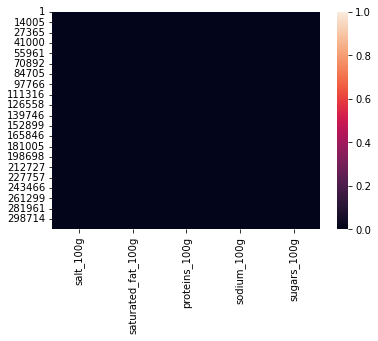

In [99]:
heatmap_nan_sorted(clean_df, ['salt_100g', 'saturated_fat_100g', 'proteins_100g', 'sodium_100g', 'sugars_100g'])

In [100]:
nan_element_indices = set()
for column in ['salt_100g', 'saturated_fat_100g', 'proteins_100g', 'sodium_100g', 'sugars_100g']:
    nan_element_indices.update(clean_df[clean_df[column].isnull() == True].index)
len(nan_element_indices)

190

La heatmap ne permet pas d'identifier la correspondance des NaN.  
Ce pendant la construction du set montre que les 190 indices correspondent parfaitement entre les 5 variables.

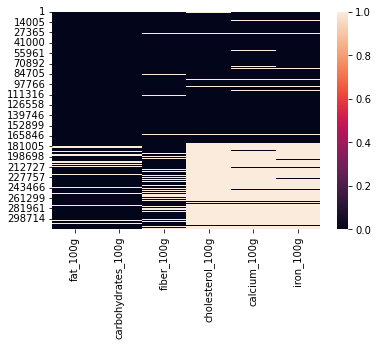

In [101]:
heatmap_nan_sorted(clean_df, ['calcium_100g', 'carbohydrates_100g', 'cholesterol_100g', 'fat_100g', 'fiber_100g', 'iron_100g'])

In [102]:
(work_df[elements_columns].isna().sum()/work_df.shape[0]).sort_values()

proteins_100g         0.126434
salt_100g             0.142040
sodium_100g           0.142205
sugars_100g           0.172702
fat_100g              0.182576
carbohydrates_100g    0.183644
saturated_fat_100g    0.222123
fiber_100g            0.320678
cholesterol_100g      0.526786
trans_fat_100g        0.530234
calcium_100g          0.533226
vitamin_c_100g        0.534563
iron_100g             0.536135
vitamin_a_100g        0.546009
dtype: float64

Le nombre de NaN permet de différencier :
- les éléments qui sont pratiquement toujours présents : le sucre, le sel, le sodium, les protéines, les graisses saturées.
- les élements assez fréquents : les graisses, les glucides, les fibres
- les élements plutôt rares : le cholestérol, la calcium, les acides gras trans, le fer, les vitamines A et C

Beaucoup de NaN coïncident avec les NaN de la variable cible.
On choisit :
- de supprimer les 190 individus dont les éléments essentiels sont absents (Les NaN sont totalement communs pour les éléments pratiquement toujours présents).
- de substituer 0 aux autres valeurs qui sont plus rares dans les aliments.

In [103]:
clean_df = clean_df.dropna(subset=['salt_100g'])

In [104]:
for column in elements_columns:
    clean_df[column] = clean_df[column].fillna(0)

In [105]:
(clean_df[elements_columns].isna().sum()/clean_df.shape[0]).sort_values()

sugars_100g           0.0
fiber_100g            0.0
sodium_100g           0.0
calcium_100g          0.0
vitamin_c_100g        0.0
carbohydrates_100g    0.0
proteins_100g         0.0
trans_fat_100g        0.0
cholesterol_100g      0.0
vitamin_a_100g        0.0
fat_100g              0.0
iron_100g             0.0
saturated_fat_100g    0.0
salt_100g             0.0
dtype: float64

2. Outliers

On peut calculer les outliers en fixant deux bornes :
- 0 puisqu'il s'agit de quantité
- 100 puisqu'il s'agit de quantité en g/mL pour 100g/100mL

In [106]:
for column in elements_columns:
    print(f'{column :<50} {len(outliers_indices(clean_df[column], 0, 100))} outliers')

sugars_100g                                        14 outliers
fiber_100g                                         2 outliers
sodium_100g                                        22 outliers
calcium_100g                                       5 outliers
vitamin_c_100g                                     2 outliers
carbohydrates_100g                                 12 outliers
proteins_100g                                      2 outliers
trans_fat_100g                                     9 outliers
cholesterol_100g                                   0 outliers
vitamin_a_100g                                     0 outliers
fat_100g                                           4 outliers
iron_100g                                          1 outliers
saturated_fat_100g                                 2 outliers
salt_100g                                          51 outliers


Sur les données restantes, il reste très peu d'outliers. On peut les supprimer sans grande conséquences sur le jeu de données.

In [107]:
for column in elements_columns:
    clean_df = clean_df.drop(outliers_indices(clean_df[column], 0, 100))

In [108]:
clean_df[elements_columns].describe()

,sugars_100g,fiber_100g,sodium_100g,calcium_100g,vitamin_c_100g,carbohydrates_100g,proteins_100g,trans_fat_100g,cholesterol_100g,vitamin_a_100g,fat_100g,iron_100g,saturated_fat_100g,salt_100g
count,208963.000000,208963.000000,208963.000000,208963.000000,208963.000000,208963.000000,208963.000000,208963.000000,208963.000000,208963.000000,208963.000000,208963.000000,208963.000000,208963.000000
mean,15.078764,2.433956,0.493617,0.057696,0.004255,30.554379,7.741020,0.040451,0.011340,0.000084,12.293052,0.001864,4.983800,1.253788
std,19.770137,4.257413,1.561350,0.370087,0.098294,28.470205,8.020239,0.743746,0.263696,0.001842,15.722935,0.137699,7.539092,3.965839
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.300000,0.000000,0.040000,0.000000,0.000000,4.700000,2.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.101600
50%,5.200000,0.900000,0.261000,0.000000,0.000000,20.000000,5.710000,0.000000,0.000000,0.000000,5.560000,0.000000,1.790000,0.662940
75%,23.330000,3.300000,0.540000,0.057000,0.000000,56.900000,10.710000,0.000000,0.000000,0.000000,20.000000,0.001290,7.140000,1.371600
max,100.000000,100.000000,39.370079,82.000000,35.714300,100.000000,100.000000,100.000000,95.238000,0.800000,100.000000,50.000000,100.000000,100.000000


##### Les additifs

In [68]:
describe_qualitative_columns(start_work_df, additives_columns)

-----------------------------------Pourcentage de NaN-----------------------------------
additives_fr      0.475077
additives         0.164805
additives_n       0.164687
additives_tags    0.475077
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
--------------------------------------additives_fr--------------------------------------
NaN                                              132118
E322 - Lécithines                                  7907
E330 - Acide citrique                              7148
E375 - Acide nicotinique,E101 - Riboflavine        6864
E300 - Acide ascorbique                            2842
E415 - Gomme xanthane                              2183
E440 - Pectines                                    1491
E100 - Curcumine                                   1188
E330 - Acide citrique,E300 - Acide ascorbique      1120
E150a - Caramel E150a                               927
Name: additives_fr, dtype: int64
--------------

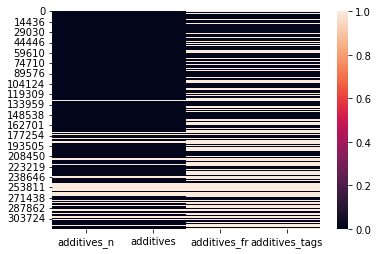

In [69]:
heatmap_nan_sorted(work_df, additives_columns)

Le nombre d'additifs est la colonne la plus renseignée.

In [70]:
len(pd.Series(nan_indices(work_df['additives_n'])))*100/work_df.shape[0]

16.468654934591402

Le pourcentage de NaN est non négligable : 16%.  
On choisit de remplacer les valeurs par la moyenne du nutriscore correspondant.

In [71]:
score_means = work_df.groupby(['nutrition_grade_fr']).mean()['additives_n']
score_means.to_dict()
score_means.apply(round)

nutrition_grade_fr
a    1
b    2
c    2
d    3
e    2
Name: additives_n, dtype: int64

In [72]:
work_df['additives_n'].fillna(work_df['nutrition_grade_fr'])
work_df['additives_n'].replace(score_means.to_dict())

0         NaN
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
320742    0.0
320743    NaN
320745    0.0
320746    NaN
320748    7.0
Name: additives_n, Length: 278098, dtype: float64

In [73]:
work_df['additives_n'] = work_df['additives_n'].fillna(0)

In [74]:
non_relevant_columns.update({'additives', 'additives_tags', 'additives_fr'})

On convertit le type de la colonne en entier.

In [75]:
work_df['additives_n'] = work_df['additives_n'].astype('int64')

##### Les colonnes sur l'huile de palme

In [76]:
describe_qualitative_columns(start_work_df, palm_oil_columns)

-----------------------------------Pourcentage de NaN-----------------------------------
palm_oil_n           0.164687
may_be_palm_oil_n    0.164687
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
----------------------------------------palm_oil_n----------------------------------------
0.0    227468
NaN     45799
1.0      4772
2.0        59
Name: palm_oil_n, dtype: int64
---------------------------------may_be_palm_oil_n---------------------------------
0.0    220970
NaN     45799
1.0      9670
2.0      1321
3.0       286
4.0        45
5.0         6
6.0         1
Name: may_be_palm_oil_n, dtype: int64


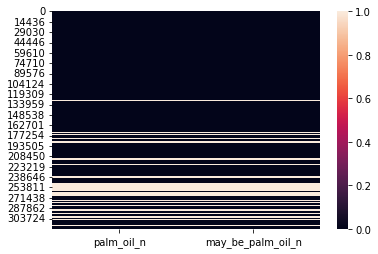

In [77]:
heatmap_nan_sorted(work_df, palm_oil_columns)

On peut regrouper les deux variables en une variable booléenne qui dira si l'aliment peut contenir de l'huile de palme ou non.

In [78]:
work_df['palm_oil'] = (work_df.may_be_palm_oil_n > 0) | (work_df.palm_oil_n > 0)

On remplace donc les deux colonnes par cette nouvelle colonne.

In [79]:
non_relevant_columns.update({'may_be_palm_oil_n', 'palm_oil_n'})

##### La liste des ingrédients

In [80]:
describe_qualitative_columns(start_work_df, ['ingredients_text'])

-----------------------------------Pourcentage de NaN-----------------------------------
ingredients_text    0.164687
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
----------------------------------ingredients_text----------------------------------
NaN                                                                                                                    45799
Almonds.                                                                                                                 154
Semoule de _blé_ dur de qualité supérieure.                                                                              108
Semolina (wheat), durum flour (wheat), niacin, ferrous sulfate (iron), thiamin mononitrate, riboflavin, folic acid.       77
Pasteurized milk, cheese culture, salt, enzymes.                                                                          66
Walnuts.                                                         

La donnée est complexe à interpréter.

In [81]:
non_relevant_columns.add('ingredients_text')

##### Allergènes

In [82]:
describe_qualitative_columns(start_work_df, ['allergens'])

-----------------------------------Pourcentage de NaN-----------------------------------
allergens    0.898223
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
-----------------------------------------allergens-----------------------------------------
NaN           249794
blé             1276
Lait             830
lait             701
soja             513
sulfites         398
céleri           274
Lait, lait       274
orge             246
lactose          231
Name: allergens, dtype: int64


Un grand nombre de NaN mais on peut supposer que l'absence de données peut signifier qu'il n'y en a pas.  
On recode la donnée en un booléen qui dit s'il y a ou non des allergènes.

In [83]:
work_df.allergens = work_df.allergens.notnull()

#### Energie

In [109]:
clean_df['energy_100g'].describe()

count    2.089630e+05
mean     1.196796e+03
std      7.163919e+03
min      0.000000e+00
25%      4.640000e+02
50%      1.184000e+03
75%      1.724000e+03
max      3.251373e+06
Name: energy_100g, dtype: float64

In [111]:
len(pd.Series(nan_indices(work_df['energy_100g'])))*100/work_df.shape[0]

12.20612877474847

In [112]:
len(pd.Series(nan_indices(clean_df['energy_100g'])))*100/clean_df.shape[0]

0.0

In [113]:
energy_outliers = pd.Series(outliers_indices_IQR(clean_df['energy_100g']))
len(energy_outliers)*100/work_df.shape[0]

0.24667563233104878

In [114]:
len(energy_outliers)

686

On compte :
- un nombre non négligeable de NaN : 12% mais ils coïncident avec les NaN du nutriscore.
- assez peu d'outliers : 686 (0.25%)

On choisit de supprimer les lignes avec les outliers, pas de traitement nécessaire pour les NaN (déjà retiré par le traitement pour le score de nutrition)

In [117]:
work_df['energy_100g'].fillna(work_df['energy_100g'].mean(), inplace=True)
energy_outliers_work = pd.Series(outliers_indices_IQR(work_df['energy_100g']))
work_df.drop(energy_outliers_work, inplace=True)

In [118]:
clean_df.drop(energy_outliers, inplace=True)

#### h) Score de nutrition

Les variables de score de nutrition informent directement sur la qualité de l'aliment pour la santé.   
La variable cible pour notre étude sera donc une variable nutrition score. 

In [84]:
nutriscore_columns = {'nutrition_score_fr_100g',
                      'nutrition_score_uk_100g',
                      'nutrition_grade_fr',}

In [85]:
describe_qualitative_columns(start_work_df, nutriscore_columns)

-----------------------------------Pourcentage de NaN-----------------------------------
nutrition_grade_fr         0.247585
nutrition_score_fr_100g    0.247585
nutrition_score_uk_100g    0.247585
dtype: float64
------------------------------Compte des valeurs par variable------------------------------
--------------------------------nutrition_grade_fr--------------------------------
NaN    68853
d      60134
c      43703
e      40681
a      32784
b      31943
Name: nutrition_grade_fr, dtype: int64
---------------------------nutrition_score_fr_100g---------------------------
 NaN     68853
 0.0     11754
 14.0    10700
 1.0     10547
 2.0     10030
 13.0     8502
 11.0     8382
 12.0     8309
-1.0      8211
 3.0      7578
 15.0     7260
 10.0     6713
Name: nutrition_score_fr_100g, dtype: int64
---------------------------nutrition_score_uk_100g---------------------------
 NaN     68853
 0.0     12577
 1.0     11210
 2.0     10504
 14.0    10137
-1.0      8234
 13.0     8085
 12.0     7

On compte beaucoup de NaN, de l'ordre de 25%. Cependant la variable est centrale dans notre étude.  
La variable nutrition_grade_fr semble la plus appropriée pour réaliser une étude (avec moins de catégorie, et plus parlante)

In [86]:
clean_df = work_df.dropna(subset=['nutrition_grade_fr'])

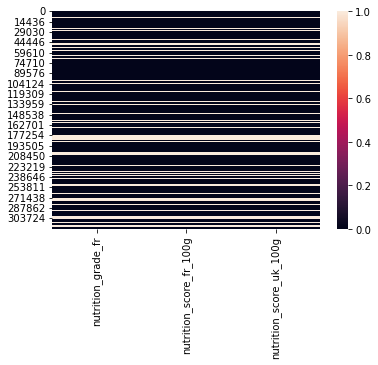

In [87]:
heatmap_nan_sorted(start_work_df,nutriscore_columns)

Les NaN coïncident, il n'y pas d'informations à reprendre des autres colonnes de score de nutrition.

In [88]:
non_relevant_columns.update({'nutrition_score_fr_100g', 'nutrition_score_uk_100g'})

##### Lieu

In [140]:
clean_df.countries_fr.fillna('Inconnu', inplace=True)

### Bilan

In [89]:
work_df = work_df.drop(columns=non_relevant_columns)

In [90]:
work_df.columns

Index(['brands', 'labels_fr', 'countries_fr', 'allergens', 'additives_n',
       'nutrition_grade_fr', 'energy_100g', 'fat_100g', 'saturated_fat_100g',
       'trans_fat_100g', 'cholesterol_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'vitamin_a_100g', 'vitamin_c_100g', 'calcium_100g',
       'iron_100g', 'category', 'palm_oil'],
      dtype='object')

In [91]:
work_df.dtypes

brands                 object
labels_fr                bool
countries_fr           object
allergens                bool
additives_n             int64
nutrition_grade_fr     object
energy_100g           float64
fat_100g              float64
saturated_fat_100g    float64
trans_fat_100g        float64
cholesterol_100g      float64
carbohydrates_100g    float64
sugars_100g           float64
fiber_100g            float64
proteins_100g         float64
salt_100g             float64
sodium_100g           float64
vitamin_a_100g        float64
vitamin_c_100g        float64
calcium_100g          float64
iron_100g             float64
category               object
palm_oil                 bool
dtype: object

#### Mise à jour Int

In [92]:
# for column in non_relevant_columns:
#     if column in int_columns:
#         int_columns.remove(column)

# for column in int_columns:
#     work_df[column] = work_df[column].astype(np.int64)

On convertit les colonnes entières qui ne l'avait pas été fait à cause des NaN lors du chargement du csv.

## Traitement

## Analyse univariée

### 1. Variables catégorielles

#### a) Nutriscore

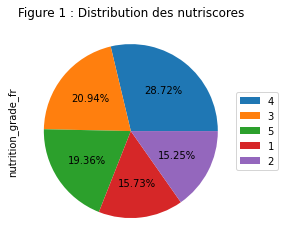

In [205]:
plt.figure()
clean_df.nutrition_grade_fr.value_counts().plot.pie(legend=True, labels=None, title='Figure 1 : Distribution des nutriscores', autopct='%1.2f%%')
plt.legend(clean_df.nutrition_grade_fr.value_counts(dropna=True).index, loc=5, bbox_to_anchor=(1.20,0.5))
plt.savefig('pie_nutriscore.png', bbox_inches="tight")
plt.show()

On remarque que le score D est le plus représenté alors que les scores A et B sont les moins représentés.

In [206]:
encode = {
    'a':1,
    'b':2,
    'c':3,
    'd':4,
    'e':5,
}
clean_df['nutrition_grade_fr'].replace(encode, inplace=True)

#### b) Catégorie

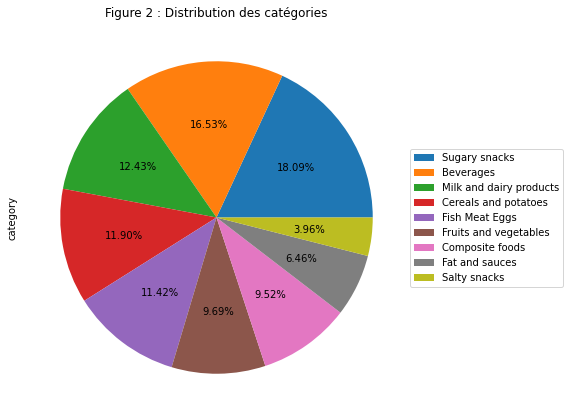

In [207]:
plt.figure()
work_df['category'].value_counts(dropna=True).plot.pie(labels=None, figsize=(7,10), autopct='%1.2f%%', title='Figure 2 : Distribution des catégories')
plt.legend(work_df['category'].value_counts(dropna=True).index, loc=5, bbox_to_anchor=(1.40,0.5))
plt.savefig('pie_category.png', bbox_inches="tight")
plt.show()

#### c) Pays

In [136]:
work_df['countries_fr'] = work_df['countries_fr'].fillna('Inconnu')

In [137]:
countries = work_df['countries_fr']
multiple_countries = countries[countries.str.contains(',', regex=False)]
countries.drop(multiple_countries.index, inplace=True)
for m in multiple_countries.tolist():
    countries.append(pd.Series(m.split()))

In [138]:
others = countries.value_counts().sum() - countries.value_counts()[:9].sum()
top_countries = countries.value_counts().head(9).append(pd.Series([others], index=["Autres"]))

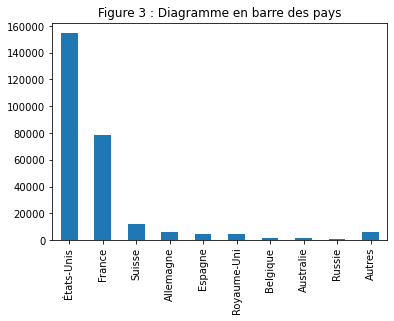

In [208]:
plt.figure()
top_countries.plot(kind='bar', title='Figure 3 : Diagramme en barre des pays')
plt.savefig(fname='barplot_countries.png', bbox_inches="tight")
plt.show()

#### d) Marque

In [157]:
other_brands = work_df.brands.value_counts().sum() - work_df.brands.value_counts()[1:10].sum()
top_brands = work_df.brands.value_counts().head(10)[1:10].append(pd.Series([others], index=["Autres"]))

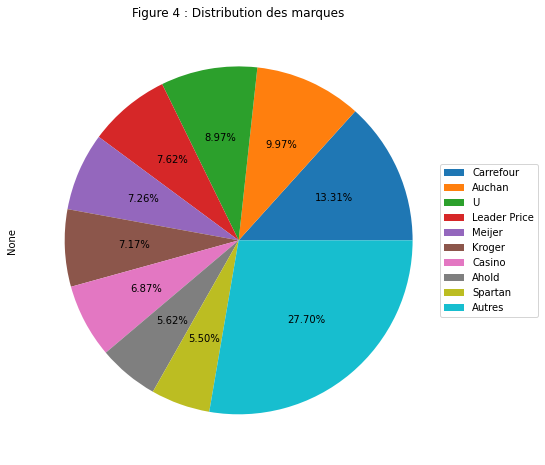

In [212]:
plt.figure()
top_brands.plot.pie(labels=None, figsize=(8,8), autopct='%1.2f%%', title='Figure 4 : Distribution des marques')
plt.legend(top_brands.index, loc=5, bbox_to_anchor=(1.20,0.5))
plt.savefig(fname='pie_brands.png', bbox_inches="tight")
plt.show()

### 2 Variables booléennes

#### a) Label

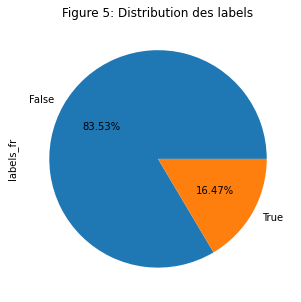

In [213]:
plt.figure()
work_df['labels_fr'].value_counts().plot.pie(figsize=(5,5), autopct='%1.2f%%', title="Figure 5: Distribution des labels")
plt.savefig(fname='pie_labels.png', bbox_inches="tight")
plt.show()

#### b) Huile de palme

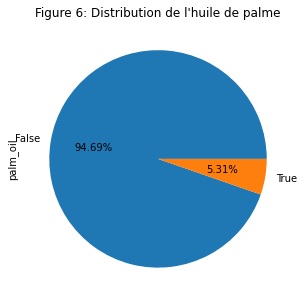

In [214]:
plt.figure()
work_df['palm_oil'].value_counts().plot.pie(figsize=(5,5), autopct='%1.2f%%', title="Figure 6: Distribution de l'huile de palme")
plt.savefig(fname='pie_palm_oil.png', bbox_inches="tight")
plt.show()

#### c) Les allergènes

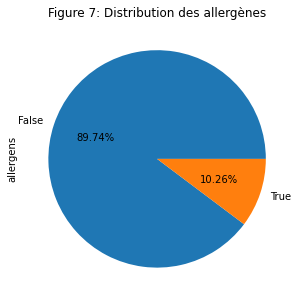

In [215]:
plt.figure()
work_df['allergens'].value_counts().plot.pie(figsize=(5,5), autopct='%1.2f%%', title="Figure 7: Distribution des allergènes")
plt.savefig(fname='pie_allergens.png', bbox_inches="tight")
plt.show()

### 3 Variables quantitatives

#### a) Eléments nutritionnels

In [95]:
elements_columns

{'calcium_100g',
 'carbohydrates_100g',
 'cholesterol_100g',
 'fat_100g',
 'fiber_100g',
 'iron_100g',
 'proteins_100g',
 'salt_100g',
 'saturated_fat_100g',
 'sodium_100g',
 'sugars_100g',
 'trans_fat_100g',
 'vitamin_a_100g',
 'vitamin_c_100g'}

In [96]:
classic_elements = {
    'calcium_100g',
    'carbohydrates_100g',
    'cholesterol_100g',
    'fat_100g',
    'fiber_100g',
    'iron_100g',
    'proteins_100g',
    'salt_100g',
    'saturated_fat_100g',
    'sodium_100g',
    'sugars_100g',
    'vitamin_a_100g',
}
particular_elements = {
    'trans_fat_100g',
    'vitamin_c_100g'
}

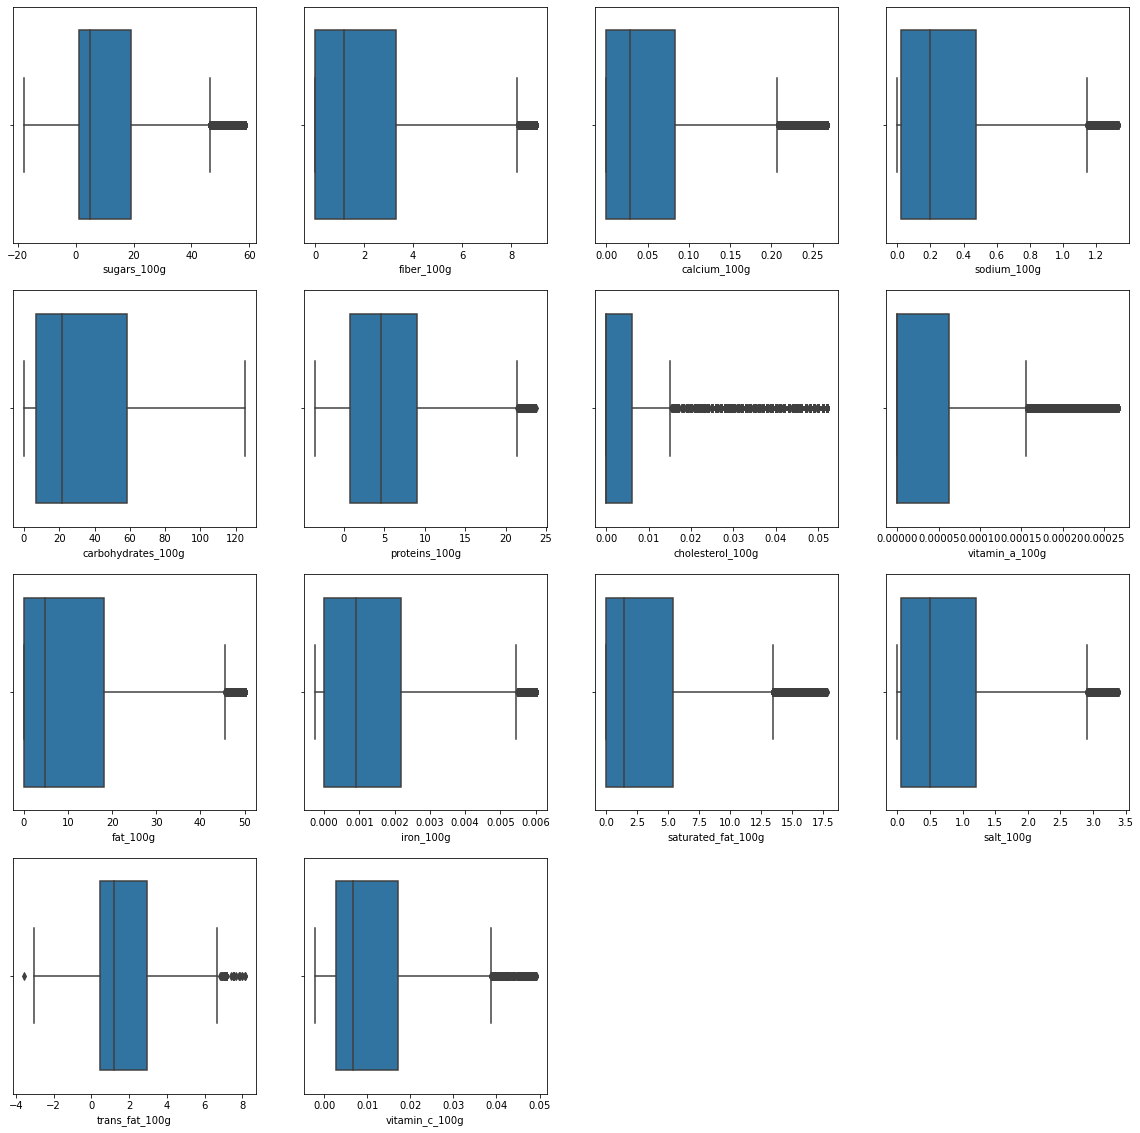

In [220]:
plt.figure(figsize=(20,20))
plt.title("Figure 8: Diagramme en boîte des éléments nutritionnels")
for count, element in enumerate(classic_elements):
    plt.subplot(4, 4, count+1)
    sns.boxplot(x=clean_outliers(work_df[element]))
for count, element in enumerate(particular_elements):
    plt.subplot(4, 4, count+13)
    sns.boxplot(x=clean_zeros(work_df[element]))
plt.savefig(fname="elements_boxplot.png")
plt.show()

On remarque que les quantités de vitamine C, d'acide gras trans ont une grande part de leur individus à 0.

#### b) L'énergie :

Il est difficile de définir des plafonds pour les valeurs aberrantes.
On utilise l'IQR pour comptabiliser leur nombre.

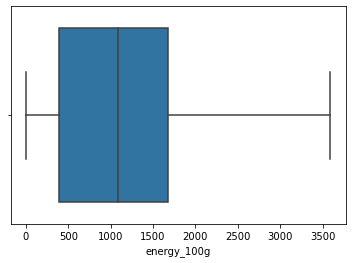

In [110]:
plt.figure()
sns.boxplot(x=clean_outliers(work_df['energy_100g']))
plt.savefig('energy_boxplot.png')

#### c) Les additifs

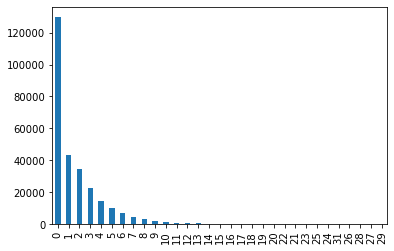

In [127]:
plt.figure()
work_df['additives_n'].value_counts().plot(kind='bar')
plt.savefig('barplot_additives.png')

## Recomposition Nutriscore 

In [ ]:
clean_df.isna().sum()

In [ ]:
# energy_level_points = [335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350]
# satured_fat_level_points = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# sugar_level_points = [4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45]
# sodium_level_points = [90, 180, 270, 360, 450, 540, 720, 810, 900]

# fruits_vegetables_nuts_level_points = [40, 60, 60, 60, 80]
# fiber_level_points = [0.7, 1.4, 2.1, 2.8, 3.5]
# proteins_level_points = [1.6, 3.2, 4.8, 6.4, 8.0]

# def level_points(energy, level):
#     for i in range(len(level)):
#         if energy<= level[i]:
#             return i
#     return 10



# def calculate_nutrition_score_uk(row):
#     A_points = level_points(row.energy_100g, energy_level_points)
#     + level_points(row.saturated_fat_100g, satured_fat_level_points)
#     + level_points(row.sugars_100g, sugar_level_points)
#     + level_points(row.sodium_100g, sodium_level_points)
#     fvn_points = level_points(row.fruits_vegetables_nuts_100g, fruits_vegetables_nuts_level_points)
#     fiber_points = level_points(row.fiber_100g, fiber_level_points)
#     C_points = fvn_points + fiber_points
#     + level_points(row.proteins_100g, proteins_level_points)
#     if A_points < 11:
#         score = A_points - C_points
#     else:
#         if level_points(row.fruits_vegetables_nuts_100g, fruits_vegetables_nuts_level_points) < 5:
#             score = A_points - (fvn_points + fiber_points)
#         else:
#             score = A_points - C_points
#     return score

# for row in data_4.iloc[1:20,:].itertuples():
#     print(f'Score: {row.nutrition_score_uk_100g}')
#     print(f'Calcul : {calculate_nutrition_score_uk(row)}')
#     print('-------------------')
# def nutriscore_columns(dataframe):
#     for row in dataframe.itertuples():
#         row

# Apprentissage non supervisé

In [ ]:
clean_df.dtypes
not_float_columns = ['brands', 'nutrition_grade_fr', 'countries_fr', 'pnns_groups_1', 'labels_fr', 'allergens', 'palm_oil']
first_ingredient_columns = ['energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g', 'fat_100g']

In [ ]:
X = clean_df[clean_df.pnns_groups_1.notnull()][first_ingredient_columns]

In [ ]:
X.head()

In [ ]:
inertia = []
K_range = range(1, 20)
for k in K_range:
    model = KMeans(n_clusters=k).fit(X)
    inertia.append(model.inertia_)

In [ ]:
plt.plot(K_range, inertia)
plt.xlabel('Nombre de clusters')
plt.ylabel('Cout du modèle (Inertia)')

## 3 clusters

In [ ]:
model = KMeans(n_clusters=3, n_init=10, max_iter=200)
model.fit(X)

In [ ]:
cluster_0 = X[model.predict(X) == 0]

In [ ]:
cluster_0

In [ ]:
cluster_0 = X[model.predict(X) == 0].index
cluster_1 = X[model.predict(X) == 1].index
cat_2 = X[model.predict(X) == 2].index

### 1ère catégorie

In [ ]:
clean_df[clean_df.index.isin(cat_0)].pnns_groups_1.value_counts()

In [ ]:
start_work_df[start_work_df.index.isin(cat_0)].pnns_groups_1.value_counts()

In [ ]:
#clean_df[clean_df.index.isin(cat_0)].nutrition_grade_fr.value_counts()

### 2ème catégorie

In [ ]:
clean_df[clean_df.index.isin(cat_1)].pnns_groups_1.value_counts()

In [ ]:
#clean_df[clean_df.index.isin(cat_1)].nutrition_grade_fr.value_counts()

### 3ème catégorie

In [ ]:
clean_df[clean_df.index.isin(cat_2)].pnns_groups_1.value_counts()

In [ ]:
#clean_df[clean_df.index.isin(cat_2)].nutrition_grade_fr.value_counts()

## 4 clusters

In [ ]:
model = KMeans(n_clusters=4, n_init=10, max_iter=200)
model.fit(X)

In [ ]:
cat4_0 = X[model.predict(X) == 0].index
cat4_1 = X[model.predict(X) == 1].index
cat4_2 = X[model.predict(X) == 2].index
cat4_3 = X[model.predict(X) == 3].index

### 1

In [ ]:
clean_df[clean_df.index.isin(cat4_0)].pnns_groups_1.value_counts()

In [ ]:
clean_df[clean_df.index.isin(cat4_0)].nutrition_grade_fr.value_counts()

### 2

In [ ]:
clean_df[clean_df.index.isin(cat4_1)].pnns_groups_1.value_counts()

In [ ]:
clean_df[clean_df.index.isin(cat4_1)].nutrition_grade_fr.value_counts()

### 3

In [ ]:
clean_df[clean_df.index.isin(cat4_2)].pnns_groups_1.value_counts()

In [ ]:
clean_df[clean_df.index.isin(cat4_2)].nutrition_grade_fr.value_counts()

### 4

In [ ]:
clean_df[clean_df.index.isin(cat4_3)].pnns_groups_1.value_counts()

In [ ]:
clean_df[clean_df.index.isin(cat4_3)].nutrition_grade_fr.value_counts()

## 5 clusters

In [ ]:
model = KMeans(n_clusters=5, n_init=10, max_iter=200)
model.fit(X)

In [ ]:
cat5_0 = X[model.predict(X) == 0].index
cat5_1 = X[model.predict(X) == 1].index
cat5_2 = X[model.predict(X) == 2].index
cat5_3 = X[model.predict(X) == 3].index
cat5_4 = X[model.predict(X) == 4].index

### 1

In [ ]:
clean_df[clean_df.index.isin(cat5_0)].pnns_groups_1.value_counts()

In [ ]:
clean_df[clean_df.index.isin(cat5_0)].nutrition_grade_fr.value_counts()

### 2

In [ ]:
clean_df[clean_df.index.isin(cat5_1)].pnns_groups_1.value_counts()

In [ ]:
clean_df[clean_df.index.isin(cat5_1)].nutrition_grade_fr.value_counts()

### 3

In [ ]:
clean_df[clean_df.index.isin(cat5_2)].pnns_groups_1.value_counts()

In [ ]:
clean_df[clean_df.index.isin(cat5_2)].nutrition_grade_fr.value_counts()

### 4

In [ ]:
clean_df[clean_df.index.isin(cat5_3)].pnns_groups_1.value_counts()

In [ ]:
clean_df[clean_df.index.isin(cat5_3)].nutrition_grade_fr.value_counts()

### 5

In [ ]:
clean_df[clean_df.index.isin(cat5_4)].pnns_groups_1.value_counts()

In [ ]:
clean_df[clean_df.index.isin(cat5_4)].nutrition_grade_fr.value_counts()

In [ ]:
clean_df.shape